# MACHINE LEARNING FOR BRAIN AND COGNITION
# Lab 05: Seizure Detection (data preprocessing and feature extraction)

##Contents:

*   What is epilepsy?
*   How EEG helps?
*   Data Importing (CHB-MIT Dataset)
*   Data Cleaning
*   Data Preprocessing (MNE package)
*   Feature Extraction (mne-features package)
*   Fit Model (XGBoost)
*   Evaluation (Confusion Matrix & ROC curve)
*   Hyperparameter Tuning (Optuna Package)

## What is Epilepsy?

* Epilepsy is characterized by abnormal electrical activities of the brain nerve cells resulting (focal or generalized) in recurrent seizures, unusual behavior, and maybe the loss of consciousness.

* Epileptic seizures occur due to excessive discharges of a group (or groups) of neurons in the cerebral cortex or hippocampus.

* It is the fourth most frequent neurological condition, affecting 70 million people worldwide.

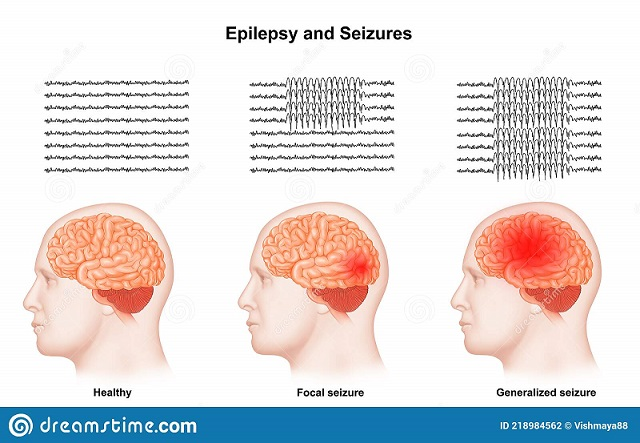

## How EEG helps?

* In order to decrease the harm of unexpected seizures and to start treatment as soon as possible, a timely and correct diagnosis of epilepsy is very compulsory for patients during a seizure state (figure 1).


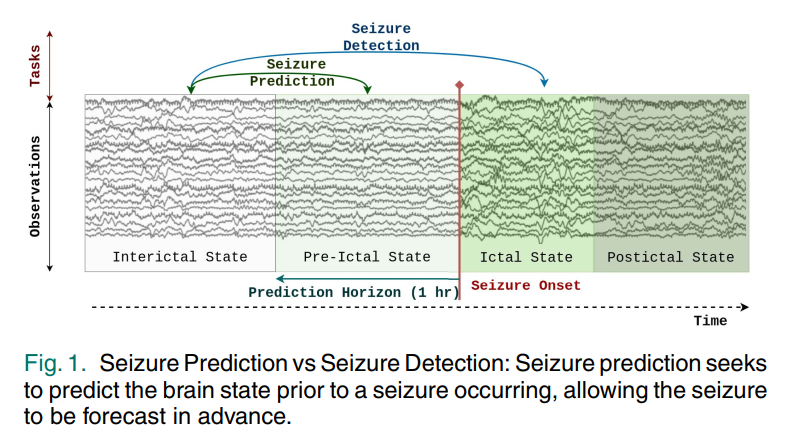

Picture reference:

"Deep Learning for Patient-Independent Epileptic Seizure Prediction Using Scalp EEG Signals," in IEEE Sensors Journal, vol. 21, no. 7, pp. 9377-9388, 1 April1, 2021.

WHen we focus on seizure detection: We have two classes: one is data from inter-ictal state and one is data from the ictal state:

When we work in seizure prediction: we should choose the interictal state as the first class and pre-ictal state as the second class. Seizure prediction is a bit harder task to classify as compared to seizure detection: Because in seizure detection we have a lot of abnormalities, while in prediction they are less.

The clinician reads the eeg report and indicates in the ictal state that the seizure has started (e.g red line.

So we are classifying into pre-ictal vs. interictal states.

If we detect the seizure early enough, we can administer a drug to stop the seizure from happenin.

We are going to classify between pre-ictal and ictal- state: Because it is very close to the seizure(ictal state)

## Import Packages

In [ ]:
# Import packages
import pandas as pd
import numpy as np

## Data Importing:

CHB-MIT Dataset:
* This database was collected at the Children’s Hospital Boston.
* Recordings, grouped into 23 cases, were collected from 22 subjects.
* All signals were sampled at 256 samples per second with 16-bit resolution.
* Most files contain 23 EEG signals (24 or 26 in a few cases).
* The International 10-20 system of EEG electrode positions and nomenclature was used for these recordings.

You can find the original dataset [HERE](https://physionet.org/content/chbmit/1.0.0/) and also, you have access to the CSV format of some important parts of the data [HERE](https://ieee-dataport.org/open-access/preprocessed-chb-mit-scalp-eeg-database).


Lots of studies work on this dataset:

You can see 24 patients with difffernet numbers of seizure: Clicking on one patient you see: chbt 01_ before the seizure.edf etc. as you can see it is a edf format and you should change the format for working in python. Maybe in brainstrom or eeglab its ok, but in pyhton you should change the format into csv file.

256 Hz 23 eeg channels

In [ ]:
# You can also just drag and drop the datafiles into the left "Data Folder"
# But everything you upload there will be temporary
# So you can use the upload to session storage button to upload the data.
seizure_df = pd.read_csv("/content/chb01_16_seizures.csv")
noseizure_df = pd.read_csv("/content/chb01_16_noseizures.csv")

In [ ]:
print("seizure_df shape:", seizure_df.shape)
print("noseizure_df shape:", noseizure_df.shape)

seizure_df shape: (13056, 23)
noseizure_df shape: (13056, 23)


We have 13056 records from 23 channels.

It is the same in seizure and nonseizure.

This data is already balanced, but in some inbalanceddata you might need to do some adjustments

We have 256Hz sampling rate, so in one second we have 256 records row

Q: How many seconds does the dataset have?

seizure duration = total raw / sampling rate = 13056 / 256 = 51 (s)

noseizure duration = total raw / sampling rate = 13056 / 256 = 51 (s)

So we have in one second 256 raw samples per second: In total 51 seconds, which means 13056 samples in total of seizure duration + same for nonseizure duration.

In [ ]:
# here we can see the channels and values in microvolts.
seizure_df.head(3)
#noseizure_df.head(3)

,# FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,...,F8-T8,T8-P8-0,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1
0,0.000097,0.000068,0.000139,0.000074,0.000174,0.000118,0.000132,-0.000044,0.000170,0.000069,...,0.000076,0.000082,-0.000004,0.000110,0.000020,-0.000139,-0.000047,0.000078,0.000083,0.000082
1,0.000088,0.000060,0.000129,0.000078,0.000168,0.000106,0.000127,-0.000044,0.000166,0.000064,...,0.000084,0.000049,-0.000019,0.000101,0.000026,-0.000128,-0.000047,0.000124,0.000097,0.000049
2,0.000077,0.000060,0.000122,0.000074,0.000157,0.000097,0.000126,-0.000045,0.000160,0.000049,...,0.000108,0.000012,-0.000032,0.000095,0.000033,-0.000122,-0.000040,0.000153,0.000112,0.000012


## Data Cleaning:

Q: Are there duplicate channels?

For data cleaning we should always check whetehr we have the same channels or not

Frist: list the channels name

In [ ]:
# Check list of the channels that we have. T8 is double:
# And a lot of studies use 23 channels & reporting the results. But it is wrong
# Because the channel is the same.
# IN this dataset you should remove the channel.
seizure_df.columns
#noseizure_df.columns

Index(['# FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3',
       'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8',
       'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10',
       'FT10-T8', 'T8-P8-1'],
      dtype='object')

Second: be sure the same names have the same values

In [ ]:
# They have also same values
seizure_df[["T8-P8-0","T8-P8-1"]].describe()
#noseizure_df[["T8-P8-0","T8-P8-1"]].describe()

,T8-P8-0,T8-P8-1
count,1.305600e+04,1.305600e+04
mean,7.981697e-07,7.981697e-07
std,1.143194e-04,1.143194e-04
min,-4.589011e-04,-4.589011e-04
25%,-7.169719e-05,-7.169719e-05
50%,2.539683e-06,2.539683e-06
75%,7.716728e-05,7.716728e-05
max,4.362393e-04,4.362393e-04


Third: remove duplicate channels

In [ ]:
seizure_data = seizure_df.drop("T8-P8-1", axis=1)
noseizure_data = noseizure_df.drop("T8-P8-1", axis=1)

print("seizure data:", seizure_data.shape)
print("noseizure data:", noseizure_data.shape)

seizure data: (13056, 22)
noseizure data: (13056, 22)


Q: Are there missing values?

In [ ]:
print(seizure_data.isnull().sum())
#print(noseizure_data.isnull().sum())
print("\n")
print("total missing values in seizure: ", seizure_data.isnull().sum().sum())
print("total missing values in noseizure: ", noseizure_data.isnull().sum().sum())

# FP1-F7    0
F7-T7       0
T7-P7       0
P7-O1       0
FP1-F3      0
F3-C3       0
C3-P3       0
P3-O1       0
FP2-F4      0
F4-C4       0
C4-P4       0
P4-O2       0
FP2-F8      0
F8-T8       0
T8-P8-0     0
P8-O2       0
FZ-CZ       0
CZ-PZ       0
P7-T7       0
T7-FT9      0
FT9-FT10    0
FT10-T8     0
dtype: int64


total missing values in seizure:  0
total missing values in noseizure:  0


## Data Preprocessing:

MNE package:

Open-source Python package for exploring, visualizing, and analyzing human neurophysiological data: MEG, EEG, sEEG, ECoG, NIRS, and more.

You can find the original website [HERE](https://mne.tools/stable/index.html).

POwerful for visualizing 3d or 2d data. Relly cool for eeg data; that you have in eeglab or brainstorm.

YOu can do it with this package its super powerful

In [ ]:
# First install mne and then import it.
!pip install mne
import mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.7 MB/s eta 0:00:00


To import our data into the mne package, firstly, we have to create an "info" variable with `mne.create_info` that needs three inputs:
* list of channels name (string values)
* sampling rate (Hz)
* type of channels (EEG, ECG,...)

In [ ]:
# create info: It needs this information to create the data.
# we use those three variables: using list function
# Using list function;: LIsts all the channels in a string
channels_lst = list(seizure_data.columns) # or "noseizure_data.columns"
# Telling the sampling rate
freq = 256 # sampling rate (Hz)

# CHannel types: Because maybe we have ecg cahnnels etc. in our case it is eeg.
# We create a for loop in the cahnnel list we have 22 and repeated eeg string!
ch_types = ['eeg' for _ in channels_lst] # all of our channels are EEG

# After creating the three channels we can finally "concatenate
#the three channel list, Hz and channel types."
info = mne.create_info(channels_lst, freq, ch_types)

In [ ]:
info

<Info | 7 non-empty values
 bads: []
 ch_names: # FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, ...
 chs: 22 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 22
 projs: []
 sfreq: 256.0 Hz
>

We have "info" now, and we can import our data into the mne package with `mne.io.RawArray`. Then we can implement different filtering according to our needs. For example, in our case, we've used the following functions:
* `notch_filter` to filter line noise from all channels. (europe - check we remove line noise- we work only between 1 Hz and 125Hz so we just remove 50 and 100 Hz.  )
* `filter` to bandpass filter
* `resample` to downsampling

You can find all the mne API filtering [HERE](https://mne.tools/stable/python_reference.html) and also you can find helpful information about filtering terminology [HERE](https://en.wikipedia.org/wiki/Filter_(signal_processing)).

In [ ]:
# import and filter seizure data
seizure_filtered = mne.io.RawArray(seizure_data.T, info) #transpose data from (13056, 22) to (22, 13056). Just for mne. Data is not changed, jsut reshaping into rows.
seizure_filtered.notch_filter(np.asarray([50,100], dtype=float)) #line noise filter from all channels
seizure_filtered.filter(l_freq=1,h_freq=125) #band pass filter 1-125 Hz
seizure_filtered.resample(sfreq=250, npad = "auto")  #downsampling to 250 Hz. If you have a very
# high sampling rate maybe you dont need this frequency, because in our study
# higher sampling rate creates a large dataset, and you dont need this huge dataset.
# So you might downsample data. TOtally depends on the study and the issue.
# In epilepsy 256 is ok. DOwnsampling is not necessary, but you can use resample

# DOing the same for no seizure data.
# import and filter noseizure data
noseizure_filtered = mne.io.RawArray(noseizure_data.T, info)
noseizure_filtered.notch_filter(np.asarray([50,100], dtype=float))
noseizure_filtered.filter(l_freq=1,h_freq=125)
noseizure_filtered.resample(sfreq=250, npad = "auto")

Creating RawArray with float64 data, n_channels=22, n_times=13056
    Range : 0 ... 13055 =      0.000 ...    50.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.0s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 125.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 126.50 Hz)
- Filter length: 845 samples (3.301 sec)

Creating RawArray with float64 data, n_channels=22, n_times=13056
    Range : 0 ... 13055 =      0.000 ...    50.996 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

<RawArray | 22 x 12750 (51.0 s), ~2.2 MB, data loaded>

---
You can see band pass filtering on 1-125 Hz (gray dashed lines) and notch
filtering on 50, and 100 Hz (two huge spikes)

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
<ipython-input-19-22705cfe9ee6>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mne.viz.plot_raw_psd(seizure_filtered)


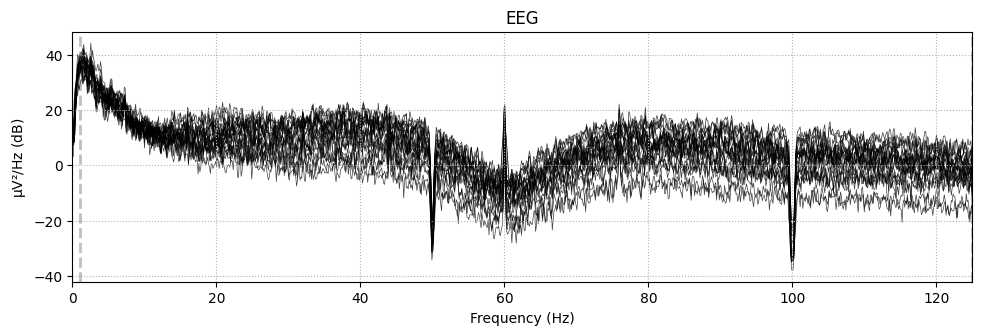

In [ ]:
mne.viz.plot_raw_psd(seizure_filtered)
#mne.viz.plot_raw_psd(noseizure_filtered)
# We can see notch filtering around 50 and 100.

---
Data preprocessing is done!

We need to return our data to the data frame according to feature extraction at the next step.

In [ ]:
# We dont need the time variable
seizure_filtered_df = (seizure_filtered.to_data_frame()).drop(labels = "time", axis = 1)
noseizure_filtered_df = (noseizure_filtered.to_data_frame()).drop(labels = "time", axis = 1)


# Check before and after: because we changed the sampling rate from 256 to 250
# We slightly undersampled. But both of them is 51 seconds.
# DUration is the same but frequency and number of the record decreased.
print("Before Data Preprocessing: ")
print("  -seizure:", seizure_data.shape)
print("  -noseizure:", noseizure_data.shape)
print("\n")
print("After Data Preprocessing: ")
print("  -seizure:", seizure_filtered_df.shape)
print("  -noseizure:", noseizure_filtered_df.shape)

# Because dividing 12750 by 250 you get 51 seconds.

Before Data Preprocessing: 
  -seizure: (13056, 22)
  -noseizure: (13056, 22)


After Data Preprocessing: 
  -seizure: (12750, 22)
  -noseizure: (12750, 22)


---
Q: Is the dataset time duration changed after preprocessing? Definitely NO!

BEFORE:

seizure duration = total raw / sampling rate = 13056 / 256 = 51 (s)

noseizure duration = total raw / sampling rate = 13056 / 256 = 51 (s)

AFTER:

seizure duration = total raw / sampling rate = 12750 / 250 = 51 (s)

noseizure duration = total raw / sampling rate = 12750 / 250 = 51 (s)

## Features Extraction

YOu can write own code for feature extraction but you can also use the package of mne here


 mne-features package:

This is a library that proposes Python code for feature extraction with M/EEG data.

e.g means, sd, but specifically for seizure detection.

You can find its website [HERE](https://mne.tools/mne-features/), and you can also find all APIs [HERE](https://mne.tools/mne-features/api.html).

In [ ]:
!pip install mne-features
from mne_features.feature_extraction import FeatureExtractor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mne-features: filename=mne_features-0.2.1-py3-none-any.whl size=26773 sha256=ff71515a1d3627816c7aeabfaec1ef8a13a7f47964368c7a03f15f03693a5026
  Stored in directory: /root/.cache/pip/wheels/96/5c/00/415905deb0928f257f59de7d4ab4a84c0b1337f37dd8ed276b
Successfully built mne-features


We need to chunk our data into small parts and then calculate each feature. We should select a **time window** and a **step window** for this goal.

NOTE: overlapping increases the number of data and overfitting risk as well.

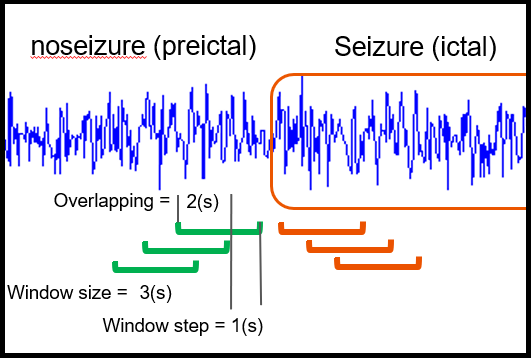

You can take timewindows, moving windows shifting, and even overlapping. A way to create a lot of little sequences for classification rather than taking all the data.

e.g here we used window size three seconds with step 1 second so we have 2 seconds overlapping for feature extraction. First choose 1 period for window size.

In this lab if we choose three seconds we have 750 records. DOwnsampling to 250 we have 750 records in 22 channels.

IMagine dataframe with 22 columns and 750 records for each patient!

BUt sometimes overlapping can create huge overfitting. But when we leave out 1 person suddenly the accuracy is super bad.

In [ ]:
dataset = []
labels = []

new_freq = 250 # after downsampling
window_size = new_freq * 3 # 3 seconds = 250*3 = 750 rows
window_step = new_freq * 1 # therefore we have 2 second overlapping = 250*2 = 500 rows

# feature extracton seizure data: We have to transpose here again.
# Here we chunk the data and calulate the mean, variance, std, skewness
seizure_transposed = np.asarray(seizure_filtered_df).T # from (12750, 22) to (22,12750)
for i in range(0, int(seizure_transposed.shape[1])-window_size, window_step):
  #choosing all channels, starting from the first each size you step the windowsize.
  # And calculate these five features for all the timewindows
  chuncked_data = seizure_transposed[: , i : i + window_size] #select "window_size" from all channels
  chuncked_data = np.expand_dims(chuncked_data, axis = 1)
  chuncked_data = chuncked_data.reshape(1,1,window_size * int(seizure_transposed.shape[0])) #reshape to one array for all channels window_size
  fe = FeatureExtractor(sfreq = new_freq , selected_funcs = ['mean', 'variance', 'std', 'skewness', 'kurtosis'])# Create the feature extractor
  # What might be the problem here? VARIANCE and SD are highly correlated
  # So using this as features: (especially in regression--> Multicolinearity )
  # some algorithms can cope with it, and make sure that you detect corelations.
  # But just be careful


  # Fitting the transform to our data.
  chuncked_data = fe.fit_transform(chuncked_data)
  dataset.extend(chuncked_data)
  labels.append(0) # assign label 0 for seizure data


# feature extraction noseizure data
noseizure_transposed = np.asarray(noseizure_filtered_df).T
for i in range(0, int(noseizure_transposed.shape[1])-window_size, window_step):
  chuncked_data = noseizure_transposed[: , i : i + window_size]
  chuncked_data = np.expand_dims(chuncked_data, axis = 1)
  chuncked_data = chuncked_data.reshape(1,1,window_size * int(noseizure_transposed.shape[0]))
  fe = FeatureExtractor(sfreq = new_freq , selected_funcs = ['mean', 'variance', 'std', 'skewness', 'kurtosis'])

  chuncked_data = fe.fit_transform(chuncked_data)
  dataset.extend(chuncked_data)
  labels.append(1) # assign label 1 for noseizure data

dataset = np.asarray(dataset)# Returning to the array:
labels = np.asarray(labels)

print(dataset.shape)# printing the shape
print(labels.shape)# we can see 5 features and number of data(96).
# 51 seconds duration of data, 3 second overlapping. 2000 divided by the size of the windows
# So we get 96 datapoints "seconds"

(96, 5)
(96,)


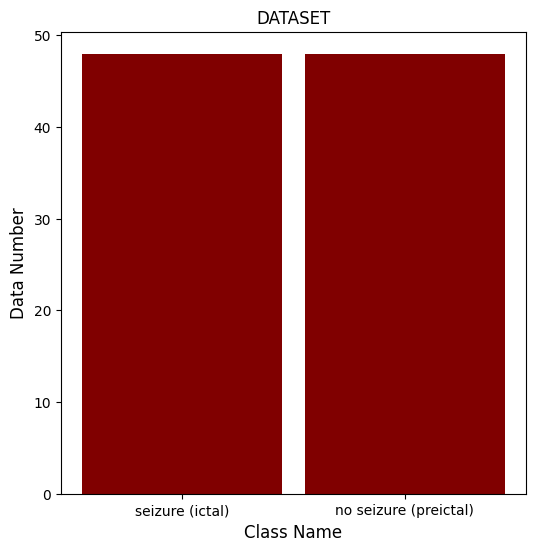

In [ ]:
# plot data
import matplotlib.pyplot as plt

plt.close() # close all open figures first

time_sections = ["seizure (ictal)","no seizure (preictal)"]
number_images = [int(np.count_nonzero(labels == 0)), int(np.count_nonzero(labels == 1))]# how many labels is 0
fig = plt.figure(figsize = (6, 6))
plt.bar(time_sections, number_images, color ='maroon', width = 0.9)
plt.xlabel("Class Name",fontsize=12)
plt.ylabel("Data Number",fontsize=12)
plt.title("DATASET",fontsize=12)
plt.show()

# Another way to plot a histogram

102 seconds is our total data:

# Lab 06: Seizure Detection (fit model, evaluation, and tuning)

## Fit Model (XGBoost)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.metrics import RocCurveDisplay, auc


cv = KFold(n_splits=5, random_state=1, shuffle=True)
sc = StandardScaler() #feature scaling
classifier = XGBClassifier(eval_metric='mlogloss', use_label_encoder =False)

# for confusion matrix
cm = np.zeros((2, 2))
accuracy = []
sensitivity = []
specificity = []

# for ROC curve
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(8,6))

for i, (train,test) in enumerate(cv.split(dataset)):
    X_train, y_train, X_test, y_test = dataset[train], labels[train], dataset[test], labels[test]

    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    #confusion matrix
    cm += confusion_matrix(y_test, y_pred)
    accuracy.append(accuracy_score(y_test, y_pred)) #accuracy
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity.append(tp / (tp+fn)) #sensitivity
    specificity.append(tn / (tn+fp)) #specificity

    #ROC curve
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        name="ROC fold {}".format(i+1),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

print("Results are READY!")

You can find more information about **sensitivity** and **specificity** [HERE](https://en.wikipedia.org/wiki/Sensitivity_and_specificity).

You can find more information about the **plot confusion matrix** [HERE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

You can find more information about **plotting the ROC curve** [HERE](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html).

## Evaluation

In [ ]:
# plot ROC curve
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC curve",
)
ax.legend(loc="lower right")

plt.show()

In [ ]:
# plot confusion matrix
plt.close()
time_sections = ["seizure","no seizure"]
plt.figure(figsize = (8, 6))
sns.set(font_scale=1.4)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g', xticklabels = time_sections, yticklabels = time_sections, annot_kws={"size": 18})
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title( "K-fold Method (XGBoost)", fontsize=14)
plt.show()

print("\n===================================================================")
print("Accuracy:    {:.2f} %".format(np.asarray(accuracy).mean()*100))
print("Sensitivity: {:.2f} %".format(np.asarray(sensitivity).mean()*100))
print("Specificity: {:.2f} %".format(np.asarray(specificity).mean()*100))
print("===================================================================")

## Hyperparameters Tuning (Optuna)

Optuna package:

An open-source hyperparameter optimization framework to automate hyperparameter search.

You can find Optuna's website [HERE](https://optuna.org/), and you can also find some examples for using it in different tasks [HERE](https://github.com/optuna/optuna-examples).

In [ ]:
!pip install optuna
import optuna

In [ ]:
import xgboost as xgb

def objective(trial):

    dtrain = xgb.DMatrix(dataset, label=labels)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-auc")
    history = xgb.cv(param, dtrain, num_boost_round=100, callbacks=[pruning_callback])

    mean_auc = history["test-auc-mean"].values[-1]
    return mean_auc


if __name__ == "__main__":
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
    study = optuna.create_study(pruner=pruner, direction="maximize")
    study.optimize(objective, n_trials=100)

    print("================================================")
    trial = study.best_trial
    print("Best Accuracy: {:.2f} %".format(trial.value*100))
    print("Best Hyperparameters: {}".format(trial.params))
    print("================================================")


In [ ]:
# compare accuracy after tuning

print("Accuracy before tuning:  {:.2f} %".format(np.asarray(accuracy).mean()*100))
print("Accuracy after tuning:   {:.2f} %".format(trial.value*100))

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

## References and more articles for curiosity:

* OShea, A., Ahmed, R., Lightbody, G., Mathieson, S., Pavlidis, E., Lloyd, R., ... & Temko, A. (2021). Deep learning for EEG seizure detection in preterm infants. arXiv preprint arXiv:2106.00611.

* B. Abdi-Sargezeh, A. Valentin, G. Alarcon and S. Sanei, "Incorporating Uncertainty In Data Labeling Into Detection of Brain Interictal Epileptiform Discharges From EEG Using Weighted optimization," ICASSP 2021 - 2021 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), 2021, pp. 1000-1004, doi: 10.1109/ICASSP39728.2021.9414463.

* Thangavel, P., Thomas, J., Peh, W. Y., Jing, J., Yuvaraj, R., Cash, S. S., ... & Dauwels, J. (2021). Time–Frequency Decomposition of Scalp Electroencephalograms Improves Deep Learning-Based Epilepsy Diagnosis. International Journal of Neural Systems, 31(08), 2150032.

* Ozdemir, M. A., Cura, O. K., & Akan, A. (2021). Epileptic eeg classification by using time-frequency images for deep learning. International Journal of Neural Systems, 2150026.

* Abrol, A., Fu, Z., Salman, M. et al. Deep learning encodes robust discriminative neuroimaging representations to outperform standard machine learning. Nat Commun 12, 353 (2021).

* Shoeibi A, Khodatars M, Ghassemi N, Jafari M, Moridian P, Alizadehsani R, Panahiazar M, Khozeimeh F, Zare A, Hosseini-Nejad H, Khosravi A, Atiya AF, Aminshahidi D, Hussain S, Rouhani M, Nahavandi S, Acharya UR. Epileptic Seizures Detection Using Deep Learning Techniques: A Review. International Journal of Environmental Research and Public Health. 2021; 18(11):5780.

* Craik, A., He, Y., & Contreras-Vidal, J. L. (2019). Deep learning for electroencephalogram (EEG) classification tasks: a review. Journal of neural engineering, 16(3), 031001.

* Lundervold, A. S., & Lundervold, A. (2019). An overview of deep learning in medical imaging focusing on MRI. Zeitschrift für Medizinische Physik, 29(2), 102-127.
